# Linear Regression<br>

The data pertains to the house block groups found in a given California district and some summary stats about them based on the 1990 census data.<br>

The columns/ features are as follows: longitude, latitude, housing median age, total_rooms, total_bedrooms, population, households, median_income, median house value, ocean_proximity.<br> The goal here is to predict the median house value based on the other features.<br>

This dataset is a modified version of the California Housing dataset available from:
Luís Torgo's page (University of Porto).

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import copy
import math
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from tensorboardX import SummaryWriter
import matplotlib as mpl 
## agg backend is used to create plot as a .png file
mpl.use('agg')

import matplotlib.pyplot as plt


%matplotlib inline

## Data Loading and Preprocessing

In [2]:
class Preprocessing:
    
    def __init__(self):
        #We keep these names so that the categorical features can be tracked even after converting them into numerical values
        self.numerical_features_name_list_including_labels = None
        self.categorical_features_namelist = None
    
    
    def set_numerical_and_categorical_feature_names(self, dataframe):
        
        #get the names of the numeric feature columns only
        self.numerical_features_name_list_including_labels = dataframe.select_dtypes(include=np.number).columns.tolist()
        #get the names of the categorical feature columns only
        list_of_categorical_feature_names = []
        for feature in dataframe.columns:
            if dataframe.dtypes[feature] == "object":
                
                list_of_categorical_feature_names.append(feature)
        self.categorical_features_namelist = list_of_categorical_feature_names
                
        
    
    
    #Custom train_test_split indices generator
    def train_test_split_indices(self, len_data, test_split_size):
        
        #Note that if a sample is to be dropped because of too many missing features, it should be done before this step.
        np.random.seed(42)
        shuffled_data_indices = np.random.permutation(len_data)
        total_test_data = int(test_split_size * len_data)
        testing_indices = shuffled_data_indices[:total_test_data]
        training_indices = shuffled_data_indices[total_test_data:]
        return training_indices, testing_indices
        
    
    
    
    
    def check_if_null_values_present(self, dataframe):
        null_dataframe = dataframe.isnull()
        total_null_values_in_each_column = null_dataframe.sum()
        return total_null_values_in_each_column
      
        
        
    def impute_missing_numerical_features_with_mean(self, dataframe):
        for feature in self.numerical_features_name_list_including_labels:
            dataframe[feature] = dataframe[feature].fillna(dataframe[feature].mean())
        return dataframe
    
    
    
    def impute_missing_categorical_features_with_the_most_frequent_values(self, dataframe):
        for feature in self.categorical_features_namelist:
            dataframe[feature].fillna(dataframe[feature].value_counts().index[0])
        return dataframe
    
    
    
    def outlier_removal(self, dataframe):
        pass

    
    #load the data from the file and split into train and test sets
#     def fetch_train_test_data(self, path): 
#         #check if null values present in the training data
#         self.check_if_null_values_present(raw_features_and_labels_from_csv)
        
#         #Note that even if the target column is passed to the imputation methods below, they are not imputed here since
#         #no target is missing
#         #training_indices, testing_indices = self.train_test_split_indices(len_data = len(raw_features_and_labels_from_csv))
        
#         raw_training_features_and_labels = raw_features_and_labels_from_csv.iloc[training_indices, :]
#         raw_testing_features_and_labels = raw_features_and_labels_from_csv.iloc[testing_indices, :]
        
#         #impute missing numerical features of training data
#         raw_features_and_labels = self.impute_missing_numerical_features_with_mean(raw_training_features_and_labels)
        
#         #impute missing categorical features of training data
#         raw_features_and_labels = self.impute_missing_categorical_features_with_the_most_frequent_values(raw_training_features_and_labels)
        
#         #record what values were used for imputation of the training data so that they can be used on test data as well
#         #make sure you dont use the test data as well to impute.
        
#         #outlier analysis of numericalfeatures of training data
        
#         features = raw_features_and_labels[features_labels]
#         labels = raw_features_and_labels[target_label]
#         #Get categorical features' names
#         list_of_categorical_feature_names = []

#         for item in features.columns:
#             if features.dtypes[item] == "object":
#                 list_of_categorical_feature_names.append(item)
        
#         features_with_categorical_features_one_hot_encoded = pd.DataFrame(self.one_hot_encode_categorical_features(features, list_of_categorical_feature_names))
#         #merge the features and labels before splitting
#         features_and_labels = features_with_categorical_features_one_hot_encoded.join(labels)
#         train_set, test_set = train_test_split(features_and_labels, test_size = 0.2, random_state = 42)    
#         return train_set, test_set
      
    
    #Handle Categorical Features
    def one_hot_encode_categorical_features(self, features, list_of_column_names_with_categorical_data ):
        
        print("Before one-hot encoding, the shape of the features: ", features.shape)
        
        
        #can use dummy variables for one-hot encoding
        
        for col in list_of_column_names_with_categorical_data:
            new_categorical_columns = pd.get_dummies(features[col])
            features = pd.concat([features, new_categorical_columns], axis = 1)
            features.drop([col], axis = 1, inplace = True)

        print("After one-hot encoding, the shape of the features: ", features.shape)
        
        print(features.head())
        return features
    
    
    
    #preprocess training data        
    def preprocess_training_data(self, training_set):
        
            training_features = training_set[training_set.columns[~training_set.columns.isin(["median_house_value"])]]
        print("Features before preprocessing training data: ", training_features.columns)
        training_targets= training_set["median_house_value"]
        #reatin column name of the targets
        training_targets = pd.DataFrame(training_targets, columns =["median_house_value"])
        
        
        print("Shape before preprocessing: ", training_features.shape)
        #training_features_and_labels.shape, training_features.shape, training_targets.shape)
        #(16512, 14)                         (16512, 13)              (16512,)
        
        #obtain the names of the features that are non-binary to standardize, we do not scale binary features
        list_of_binary_features = [col for col in training_features if np.isin(training_features[col].unique(), [0, 1]).all()]
        list_of_nonbinary_features = []
        
        for feat in training_features.columns:
            if feat not in list_of_binary_features:
                list_of_nonbinary_features.append(feat)
                
        print("Binary features: ", list_of_binary_features)
        print("Non-binary features: ", list_of_nonbinary_features)
                
        
        nonbinary_training_features = training_features[list_of_nonbinary_features]
        binary_training_features = training_features[list_of_binary_features]
        
        #reset the indices for both
        nonbinary_training_features.reset_index(inplace = True, drop = True)
        binary_training_features.reset_index(inplace = True, drop = True)
        
        print(nonbinary_training_features.head())
        print(binary_training_features.head())
        print("0000000000000000---------------------------------------------")
        
        
        print("Shape binary_training_features : ", binary_training_features.shape)

        
        #normalize the non-binary features
        scaler = StandardScaler()
        scaler.fit(nonbinary_training_features)
        scaled_nonbinary_features = pd.DataFrame(scaler.transform(nonbinary_training_features))
        print("Here ",scaled_nonbinary_features.head())
        #retain the column names
        scaled_nonbinary_features.columns = list_of_nonbinary_features
        print("Hereeee ",scaled_nonbinary_features.head())
        print("Shape scaled_nonbinary_features : ", scaled_nonbinary_features.shape)
        print("Shape binary_training_features : ", binary_training_features.shape)

        #concat the scaled nonbinary features and binary features
        features_without_bias = pd.concat([scaled_nonbinary_features, binary_training_features], axis = 1)
        print("features without bias: ", features_without_bias.columns)
        print("features without bias: ", features_without_bias.head())
        
        print("Shape features_without_bias : ", features_without_bias.shape)

        
        
        #create a bias of all ones
        bias_feature = pd.DataFrame(np.ones(len(training_features)).reshape((len(training_features),1)))
        #add column name to the bias feature
        bias_feature.columns = ["bias_term"]
        
        print("No. of features before adding the bias feature: ", features_without_bias.shape)   
        
        #stack the new bias feature to the left of the regular features using the axis argument
        features_with_bias = pd.concat([bias_feature, features_without_bias], axis = 1)
        print("No. of features after adding the bias feature: ", features_with_bias.shape)
        
        print("Features after processing training data: ",features_with_bias.columns)
        return scaler, features_with_bias, training_targets
                

        
    
    #preprocess testing data
    def preprocess_test_data(self, scaler, testing_set):
        
        testing_features = testing_set[testing_set.columns[~testing_set.columns.isin(["median_house_value"])]]
        
        testing_targets= testing_set["median_house_value"]
        
        #wrong, need to separate nonbinary features before applying the scaler
            
        #transform the features using the parameters from the training data
        scaled_features =  pd.DataFrame(scaler.transform(testing_features))
        #bias of all ones
        bias_feature = pd.DataFrame(np.ones(len(scaled_features)).reshape((len(scaled_features),1)))

        #stack the new bias feature to the left of the regular features using the axis argument
        features_with_bias = pd.concat([bias_feature, scaled_features], axis = 1)
        return features_with_bias, testing_targets

    

## Visualization Module

In [3]:
         
        
        #Studt the following:
        
        #remove outlier using the feature distribution plot as enna said
        
        #assumptions of multiple linear regression about residuals
        
    
    

## Vectorized Gradient Descent Module


In [4]:
class Gradient_Descent:
    
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    
    def update_parameters(self, Theta, X, Y):
        
        X_times_Theta = X.dot(Theta)
        X_time_Theta_minus_Y = X_times_Theta - Y
        X_transpose = X.T
        gradient_of_loss = X_transpose.dot(X_time_Theta_minus_Y)
        new_weights = Theta - self.learning_rate * gradient_of_loss
        return new_weights

## Regression Module

In [5]:
class Regression:
    
    def __init__(self, max_iters, features_train, targets_train, features_test, targets_test, scaler_used_for_features):
        self.writer = SummaryWriter()
        self.max_iters = max_iters
        self.features_train = features_train
        self.targets_train = targets_train
        self.features_test = features_test
        self.scaler_used_for_features = scaler_used_for_features
        
        self.gradient_descent = Gradient_Descent(learning_rate = 0.001)
    
    
    
    
    
    def calculate_regression_loss(self, X, Theta, Y):
        
        X_times_Theta = X.dot(Theta)
        X_times_Theta_minus_Y = X_times_Theta - Y
        loss = (1/ (2 * len(Y))) * (X_times_Theta_minus_Y.T).dot(X_times_Theta_minus_Y)    
        return loss
    
    
    
    
    

class Linear_Regression(Regression):

                        
    def batch_gradient_descent_train(self):
        
        #Initialize random weights and biases
        weights = pd.DataFrame(pd.DataFrame(np.random.randint(0,100,size=self.features_train.shape[1])).values.reshape(1, self.features_train.shape[1]))
        epoch = 0
        while epoch < max_iters:
            print("Training Iteration No: ", epoch)
            
            loss_in_epoch = 0
            
            #Get a shuffled list of indices of training data. (Not required when using batch gradient descent though)
            #shuffled_indices = np.random.permutation(len(self.features_train))
            
            weights = self.gradient_descent.update_parameters(weights, self.features_train, self.targets_train)
            
            training_loss_in_epoch = self.calculate_regression_loss(self.features_train, weights, self.targets_train)
            
            testing_loss_in_epoch = self.calculate_regression_loss(self.features_test, weights, self.targets_test)
            
            self.writer.addscalar("Linear Regression Batch GD Training Loss",training_loss_in_epoch, iter)
            self.writer.addscalar("Linear Regression Batch GD Testing Loss",testing_loss_in_epoch, iter) 
    

## Execution

### Train/ Test Split

In [6]:
raw_csv_path = r"C:\Users\Being_Aerys\PycharmProjects\Machine_Learning_Algorithms_Collection\Supervised_Methods\Linear_Regression\data\housing.csv"

#Split data into train-test sets before any analysis/ imputation/ visualization to avoid data leakage
preprocessing = Preprocessing()

COPY_OF_RAW_DATASET_FOR_ANALYSIS_PURPOSE = pd.read_csv(raw_csv_path, sep = ",",)

COPY_OF_RAW_DATASET_FOR_TRAINING_PURPOSE = copy.deepcopy(COPY_OF_RAW_DATASET_FOR_ANALYSIS_PURPOSE)

training_indices, testing_indices = preprocessing.train_test_split_indices(len(COPY_OF_RAW_DATASET_FOR_ANALYSIS_PURPOSE), 0.2)
train_set, test_set = COPY_OF_RAW_DATASET_FOR_ANALYSIS_PURPOSE.iloc[training_indices], COPY_OF_RAW_DATASET_FOR_ANALYSIS_PURPOSE.iloc[testing_indices]

preprocessing.set_numerical_and_categorical_feature_names(train_set)

train_set.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.582290,35.643149,28.608285,2642.004784,538.496851,1426.453004,499.986919,3.880754,207194.693738
std,2.005654,2.136665,12.602499,2174.646744,419.007096,1137.056380,380.967964,1.904294,115622.626448
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.810000,33.930000,18.000000,1454.000000,296.750000,789.000000,280.000000,2.566700,119800.000000
50%,-118.510000,34.260000,29.000000,2129.000000,437.000000,1167.000000,410.000000,3.545800,179850.000000
75%,-118.010000,37.720000,37.000000,3160.000000,647.000000,1726.000000,606.000000,4.773175,265125.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Null Value Removal

In [7]:
no_of_null_values_in_training_data = preprocessing.check_if_null_values_present(train_set)
print(f"Total null values present in different features of training data:\n {no_of_null_values_in_training_data}\n" )


Total null values present in different features of training data:
 longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64



### Imputation of Missing Values

In [8]:
#Impute the missing values in the training data before visualizing the distribution that will be used for learning (This order is not mandatory but rather a tradeoff.)
train_set = preprocessing.impute_missing_numerical_features_with_mean(train_set)
train_set = preprocessing.impute_missing_categorical_features_with_the_most_frequent_values(train_set)
#Note that there are no missing values in the labels column and thus no imputation happens for the labels.



### Outlier Detection in Features

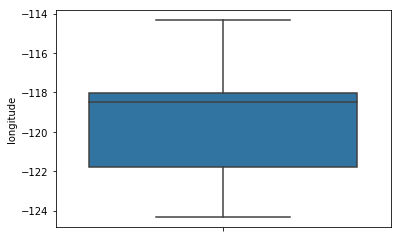

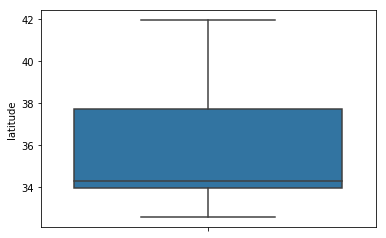

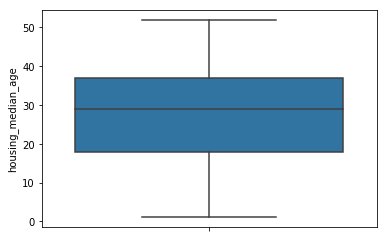

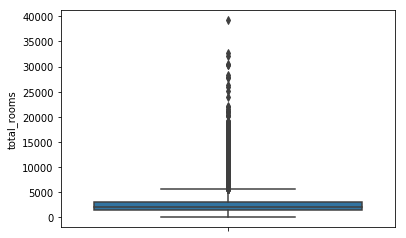

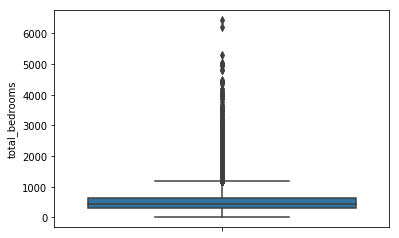

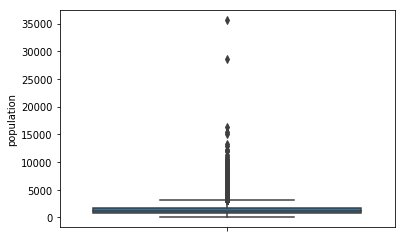

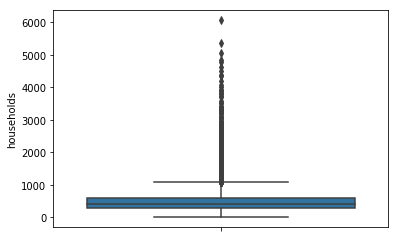

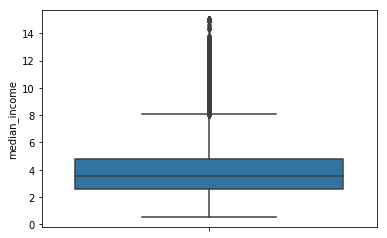

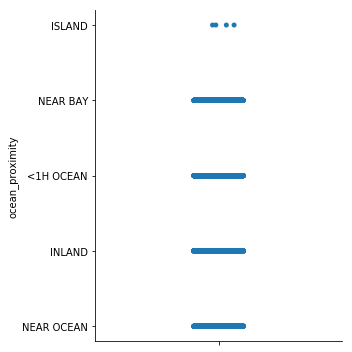

In [9]:

#Display thge boxplot of numerical and categorical features (ignore the target labels)
dataframe_of_training_features_only = train_set[train_set.columns[~train_set.columns.isin(["median_house_value"])]]
numerical_cols = preprocessing.numerical_features_name_list_including_labels
categorical_cols = preprocessing.categorical_features_namelist

#Numerical features
for col in numerical_cols:
    if col != "median_house_value":
        sns.boxplot(y = col , data = dataframe_of_training_features_only)
        plt.show() 

#Categorical features
for col in categorical_cols:

    sns.catplot(y = col , data = dataframe_of_training_features_only)
    plt.show() 

Even though there are samlpes outside 1.5IQR in several features, in this case, they are not outliers. The number of bedrooms, rooms, median income all point toward certain blocks in California that are densely populated.

### Linear Regression Assumption Validation: Independence among Features Test

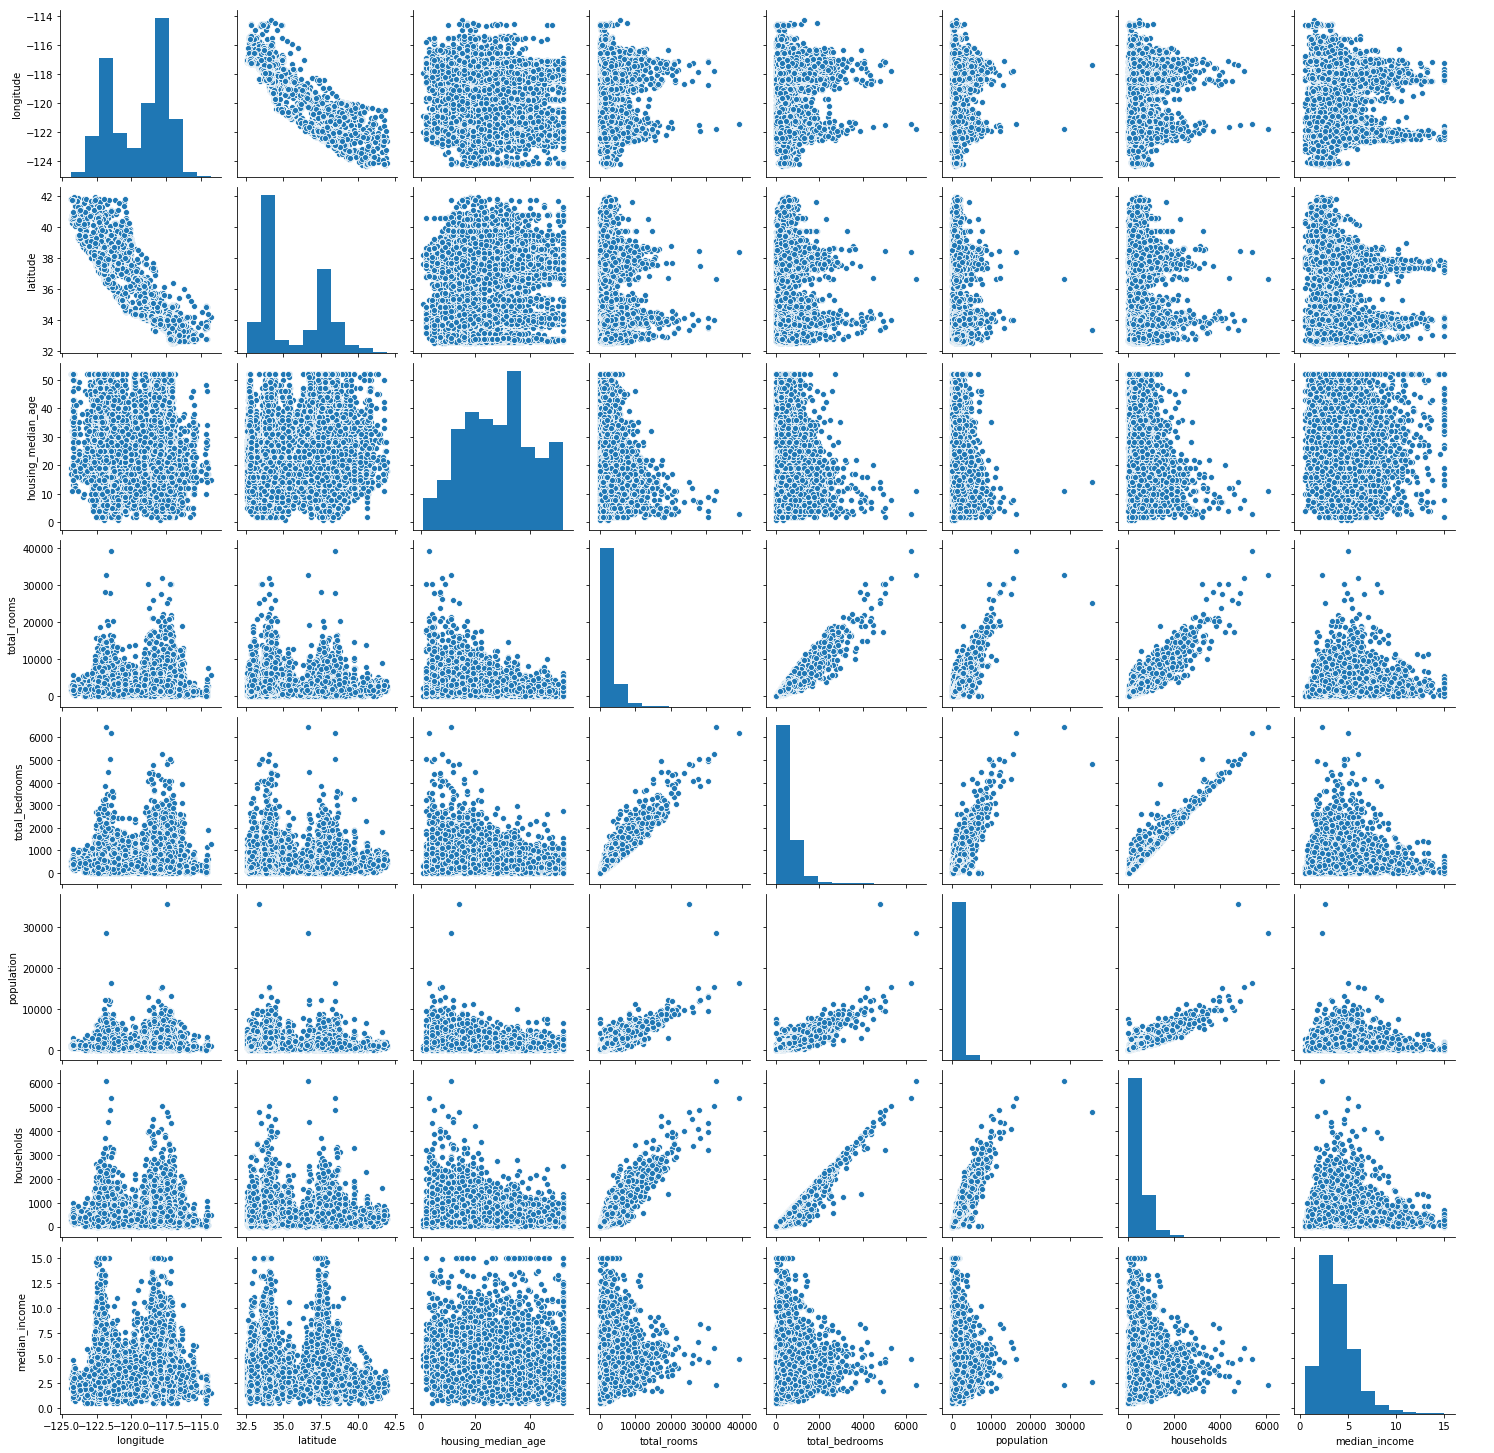

In [166]:
#Observe the correlation among the numerical features to eliminate multicollinearity
sns.pairplot(train_set[train_set.columns[~train_set.columns.isin(["median_house_value"])]])


From the scatterplots above, it is seen that there exists some level of correlation among some feature pairs. For example, total bedrooms and households have a positive correlation. Similarly, total bedrooms and total rooms also have a correlation. For the sake of simplicity, however, we will proceed without dealing with this here.

### One-Hot Encoding Categorical Data (Introduces Multicollinearity though)

In [10]:
#onehot encode the categorical columns (since the label is a continuous value, this does not affect the label)
features_with_onehot_encoding = preprocessing.one_hot_encode_categorical_features(COPY_OF_RAW_DATASET_FOR_TRAINING_PURPOSE, preprocessing.categorical_features_namelist)

#Separate the training and testing data using the indices generated during analysis
train_set, test_set = features_with_onehot_encoding.iloc[training_indices], features_with_onehot_encoding.iloc[testing_indices]



Before one-hot encoding, the shape of the features:  (20640, 10)
After one-hot encoding, the shape of the features:  (20640, 14)
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  <1H OCEAN  \
0       322.0       126.0         8.3252            452600.0          0   
1      2401.0      1138.0         8.3014            358500.0          0   
2       496.0       177.0         7.2574            352100.0          0   
3       558.0       219.0         5.6431            341300.0          0   
4       565.0       259.0         3.8462     

### Standardization

In [11]:

scaler_used_for_features, standardized_training_features, training_labels = preprocessing.preprocess_training_data(train_set)




Features before preprocessing training data:  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype='object')
Shape before preprocessing:  (16512, 13)
Binary features:  ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
Non-binary features:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -117.03     32.71                33.0       3126.0           627.0   
1    -118.16     33.77                49.0       3382.0           787.0   
2    -120.48     34.66                 4.0       1897.0           331.0   
3    -117.11     32.69                36.0       1421.0           367.0   
4    -119.80     36.78                43.0       2382.0           431.0   

   popul

### Outlier Test in Targets

In [ ]:
#check for outliers in the target
sns.distplot(training_labels)

There appears to be no sample with a target value significantly farther from the majority of the samples. Hence no outlier removal required based on the target observation.

### Remove any outlier based on the features.
(Not required in this data set since outliers not present. Only plotting the distributions here.)

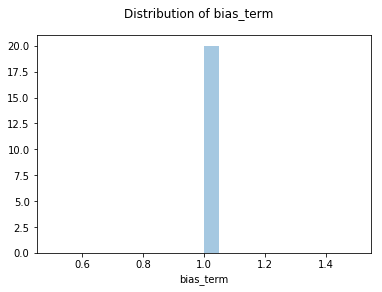

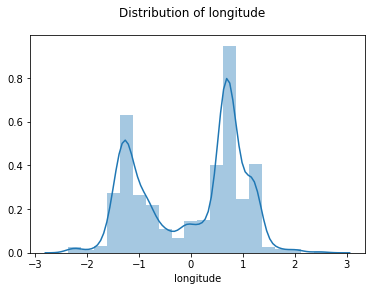

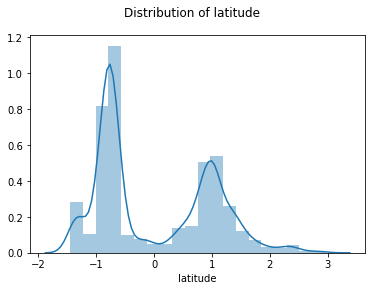

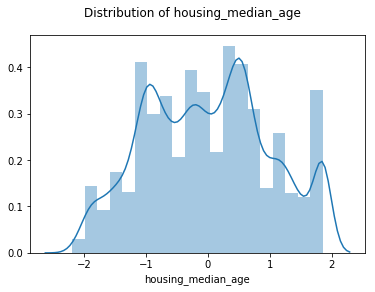

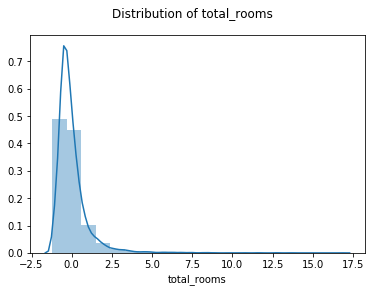

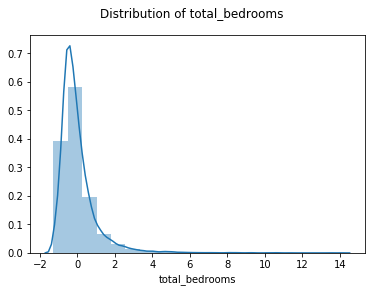

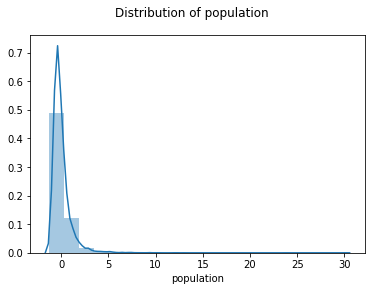

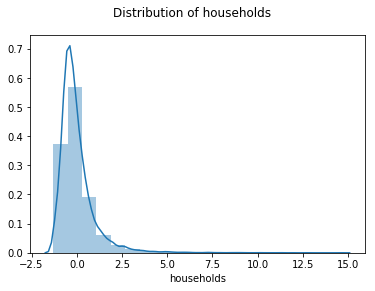

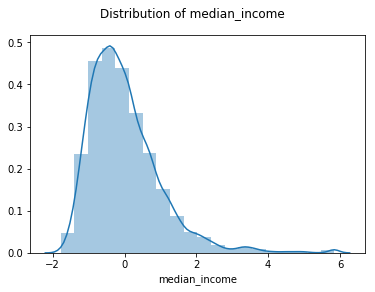

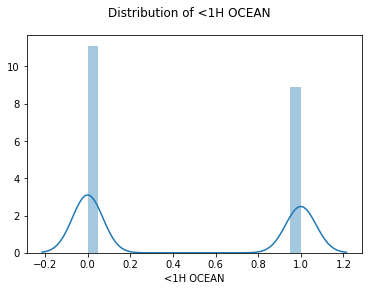

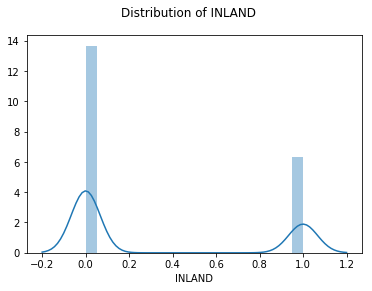

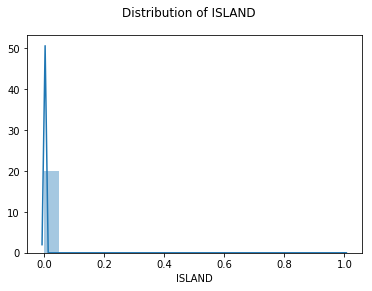

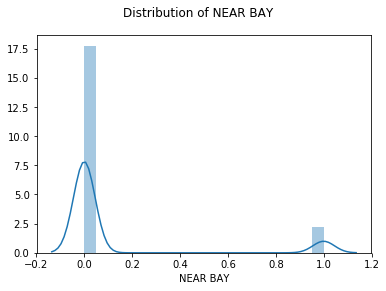

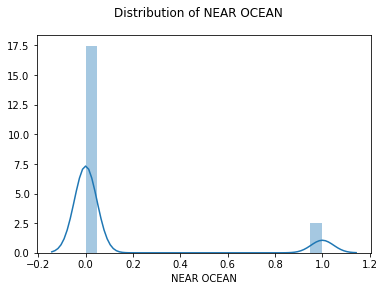

In [13]:




#get the names of the numeric feature columns only
numerical_cols = standardized_training_features.select_dtypes(include=np.number).columns.tolist()
#get the names of the categorical feature columns only
categorical_cols = []
for feature in standardized_training_features.columns:
    if standardized_training_features.dtypes[feature] == "object":

        categorical_cols.append(feature)




#Numerical features
for col in numerical_cols:
    if col != "median_house_value":
        fig = plt.figure()
        sns.distplot(standardized_training_features[col], bins = 20)
        fig.suptitle("Distribution of "+col)
        #fig.xlabel(col, fontsize = 18)
        plt.show() 

#Categorical features
for col in categorical_cols:

        fig = plt.figure()
        sns.distplot(standardized_training_features[col], bins = 20)
        fig.suptitle("Distribution of "+col)
        #fig.xlabel(col, fontsize = 18)
        plt.show() 


### Linear Regression Assumption Validation: Linear Relation between Feature X and Label Y

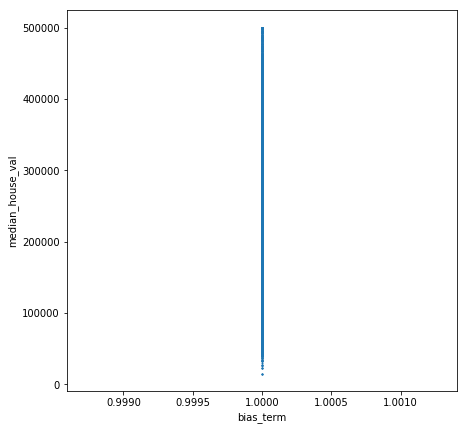

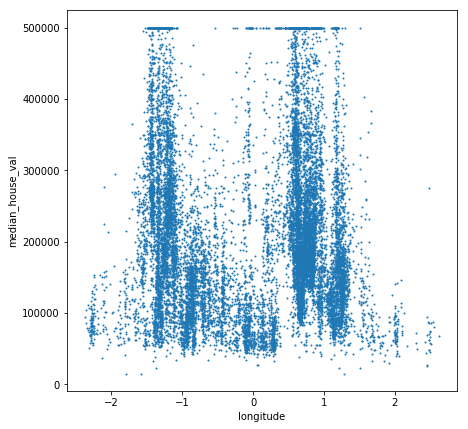

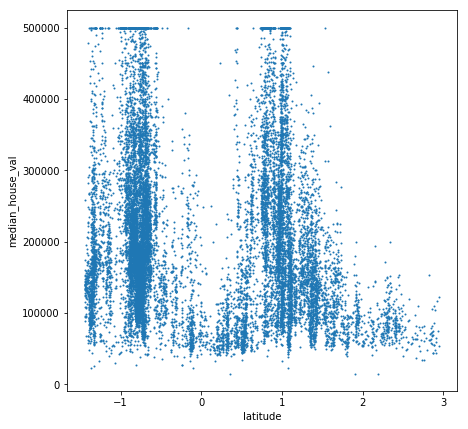

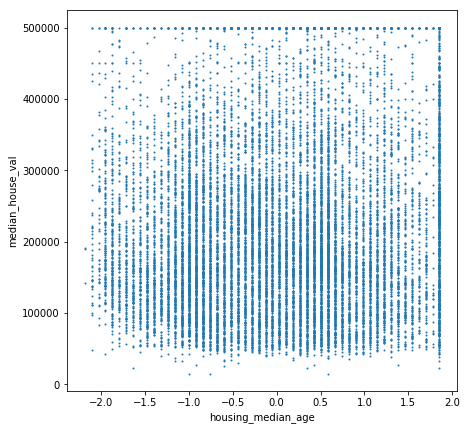

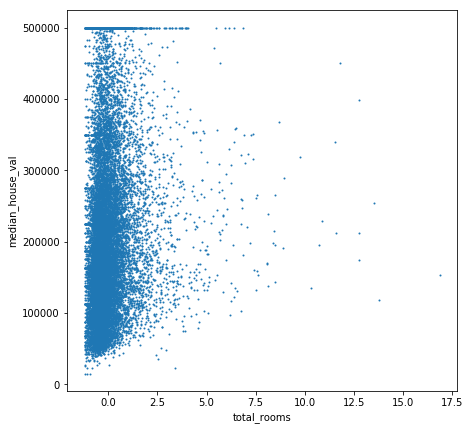

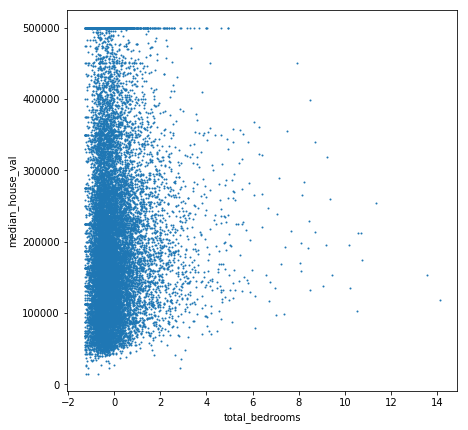

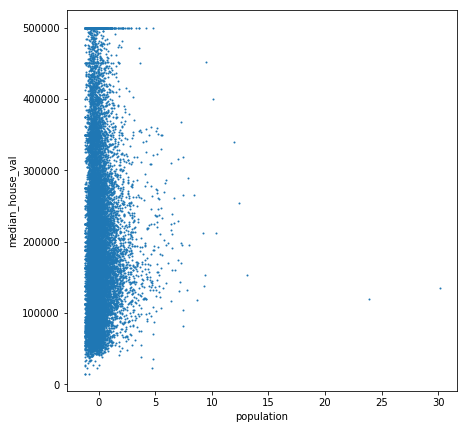

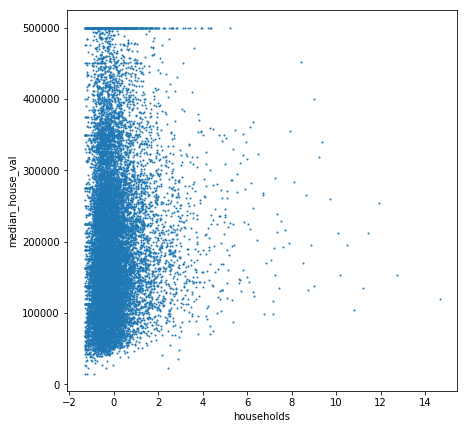

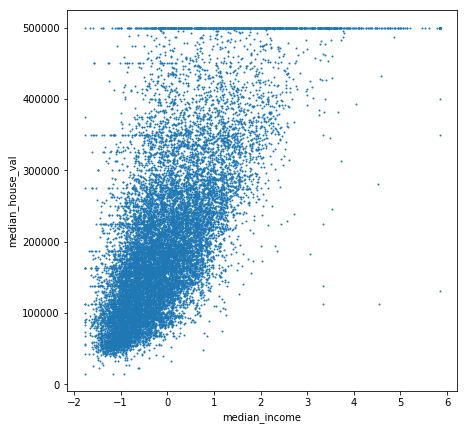

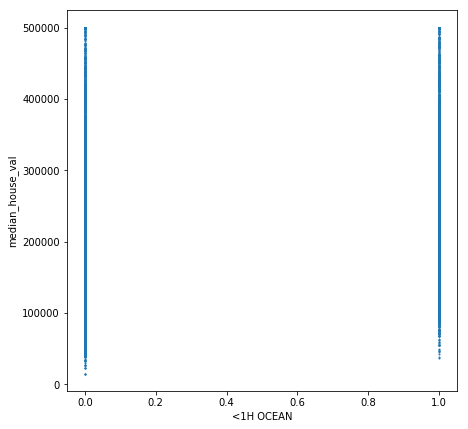

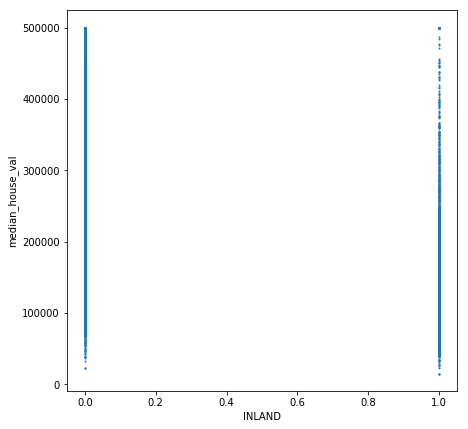

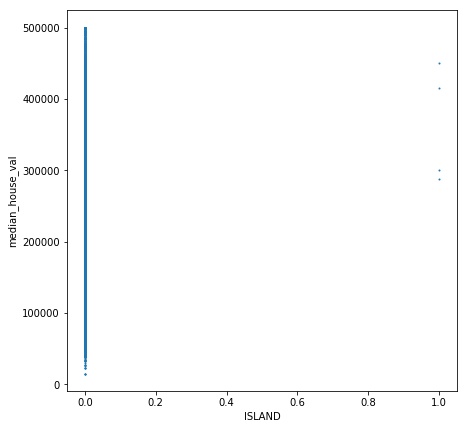

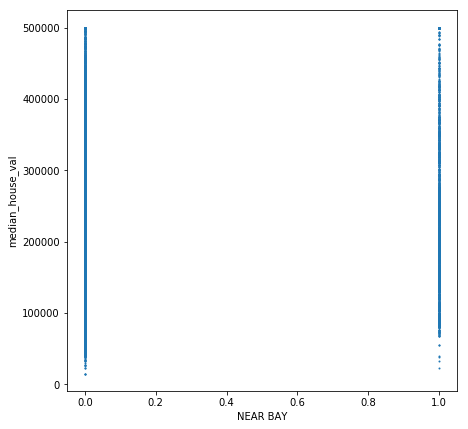

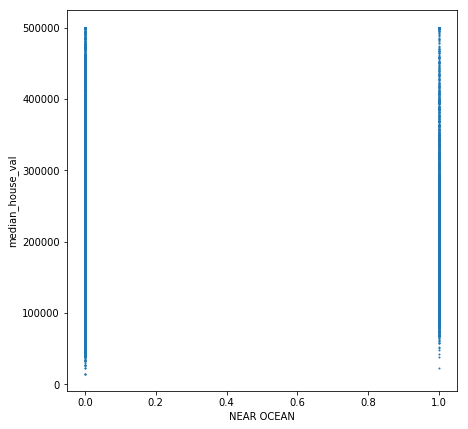

In [18]:


#Numerical features
for col in numerical_cols:
    if col != "median_house_value":
        
        #Size of the figure
        plt.scatter(standardized_training_features[col], training_labels, s = 1)
        #plt.title('Scatter Plot')
        plt.xlabel(col)
        plt.ylabel("median_house_val")
        plt.show() 

#Categorical features
for col in categorical_cols:
        
        #Size of the figure
        plt.figure(figsize=(7,7))

        plt.scatter(standardized_training_features[col], training_labels, s = 1)
        #plt.title('Scatter Plot')
        plt.xlabel(col)
        plt.ylabel("median_house_val")
        plt.show() 


If there appears to be heteroscedasticity in the scatterplot of an independent variable vs the response variable, log-transformation of the independent variable might help to reduce that. Also, log transformation of the response variable can be done at times but this should be done wrt to all the independent variables unlike the log transformation of just one (or a subset of) independent variable(s). Also, log transformation of both, the independent variables as well as the response variable is also possible.

In [ ]:
#Lets summarize the information of the training data set.

test_features, test_labels = preprocessing.preprocess_test_data(scaler_used_for_features, test_set)

max_iters = 25

linear_regression = Linear_Regression(max_iters, standardized_training_features, training_labels, test_features, test_labels, scaler_used_for_features)

linear_regression.batch_gradient_descent_train()

It appears that one of the features "ocean_proiximity" is a categorical features. If a categorical feature is has two only two classes, they can be encoded as binary features. However, if there are more than 2 categories, they can be either label encoded or one-hot encoded. Label encoding means assigning an integer to each class. However, consider a case where the feature represents the color of the eyes of an individual. If the labelling is done as black eyes --> 1, brown eyes --> 1, blue eyes --> 2, green eyes --> 3, the algorithm that takes in this information will interpret as one color being "larger" than the other color, which is not what we intend to tell. Hence, in such cases, one-hot encoding comes to our rescue which does not present such bias to the algorithm.

In [ ]:
handling date data tpe, if the feature's distribution is not gaussian, since linear regression requires this, we cn standardize to make it.
this also --> homoscedasticity, stamdardization vs normalizetion in linear regressop? --> satisfy asusmptions by standardizarion?

does normalization increase accuracy, are linear regression weights reflection of feature importance